# Step 2: Streaming Baseline – SAND

In this notebook, we evaluate the **SAND (Streaming Subsequence Anomaly Detection)** method on the Normality 1–3 datasets using a streaming simulation.

Data is processed in **small overlapping windows** (subsequences), mimicking real-time streaming input. SAND incrementally builds a model of normal subsequences and scores each new window to detect anomalies.


In [1]:
# Imports
import os, numpy as np, pandas as pd, matplotlib.pyplot as plt
from sklearn.metrics import precision_score, recall_score, f1_score, roc_auc_score
from TSB_UAD.models.sand import SAND

# Configuration
DATA_DIR    = "generated_datasets"
RESULTS_DIR = "results_streaming"
os.makedirs(RESULTS_DIR, exist_ok=True)

# SAND hyperparameters
SUBSEQ_LEN    = 20
PATTERN_LEN   = 10      # KEEP SMALL to avoid internal stumpy crash
INIT_LEN      = 400
BATCH_SIZE    = 300
ALPHA         = 0.5
OVERLAP       = 5
CONTAMINATION = 0.05
K_CLUSTERS    = 6

In [ ]:
def run_sand_stream(ts):
    min_required = INIT_LEN + BATCH_SIZE + PATTERN_LEN
    if len(ts) < min_required:
        print(f"Dataset too short: {len(ts)} < {min_required}")
        return None, None

    print(f"Fitting with: pattern_len={PATTERN_LEN}, subseq_len={SUBSEQ_LEN}, init_len={INIT_LEN}, batch_size={BATCH_SIZE}")
    try:
        model = SAND(
            pattern_length=PATTERN_LEN,
            subsequence_length=SUBSEQ_LEN,
            k=K_CLUSTERS
        )

        model.fit(
            X=ts,
            online=True,
            alpha=ALPHA,
            init_length=INIT_LEN,
            batch_size=BATCH_SIZE,
            overlaping_rate=OVERLAP,
            verbose=False
        )

        scores = np.array(model.decision_scores_)
        if len(scores) == 0:
            print("No scores generated.")
            return None, None

        threshold = np.percentile(scores, 100 * (1 - CONTAMINATION))
        preds = (scores > threshold).astype(int)
        return preds, scores

    except Exception as e:
        print(f"Skipped due to error: {e}")
        return None, None


▶️ Processing normality_1_daphnet.npy
   ▶️  Fitting with: pattern_len=10, subseq_len=20, init_len=400, batch_size=300


c:\Users\maria\OneDrive\Υπολογιστής\ΜΕΤΑΠΤΥΧΙΑΚΟ\BIG DATA MINING\Streamify-Time-Series\venv310\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
c:\Users\maria\OneDrive\Υπολογιστής\ΜΕΤΑΠΤΥΧΙΑΚΟ\BIG DATA MINING\Streamify-Time-Series\venv310\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
c:\Users\maria\OneDrive\Υπολογιστής\ΜΕΤΑΠΤΥΧΙΑΚΟ\BIG DATA MINING\Streamify-Time-Series\venv310\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
c:\Users\maria\OneDrive\Υπολογιστής\ΜΕΤΑΠΤΥΧΙΑΚΟ\BIG DATA MINING\Streamify-Time-Series\venv310\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 

   ✅ Precision: 0.015, Recall: 0.015, F1: 0.015, AUC: 0.478


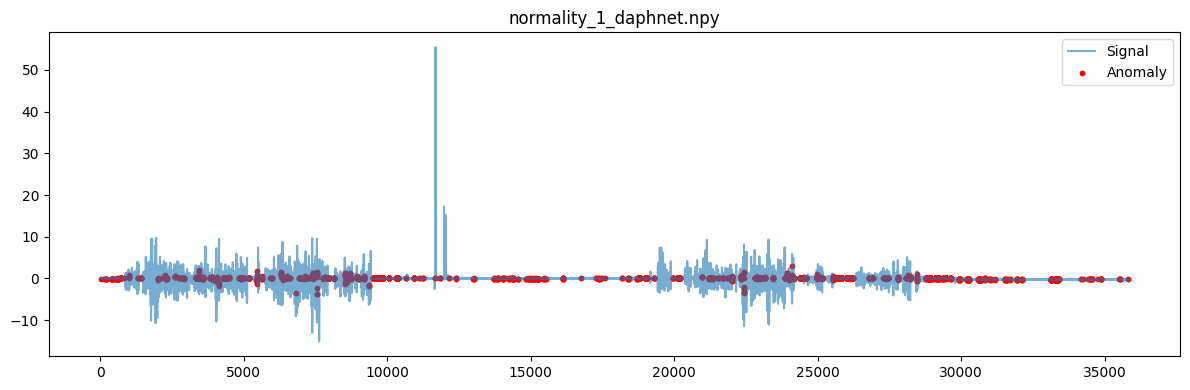


▶️ Processing normality_1_genesis.npy
   ▶️  Fitting with: pattern_len=10, subseq_len=20, init_len=400, batch_size=300


c:\Users\maria\OneDrive\Υπολογιστής\ΜΕΤΑΠΤΥΧΙΑΚΟ\BIG DATA MINING\Streamify-Time-Series\venv310\lib\site-packages\stumpy\core.py:3467: UserWarning: A large number of values in `P` are smaller than 1e-06.
For a self-join, try setting `ignore_trivial=True`.
  warnings.warn(msg)
c:\Users\maria\OneDrive\Υπολογιστής\ΜΕΤΑΠΤΥΧΙΑΚΟ\BIG DATA MINING\Streamify-Time-Series\venv310\lib\site-packages\stumpy\core.py:3467: UserWarning: A large number of values in `P` are smaller than 1e-06.
For a self-join, try setting `ignore_trivial=True`.
  warnings.warn(msg)
c:\Users\maria\OneDrive\Υπολογιστής\ΜΕΤΑΠΤΥΧΙΑΚΟ\BIG DATA MINING\Streamify-Time-Series\venv310\lib\site-packages\stumpy\core.py:3467: UserWarning: A large number of values in `P` are smaller than 1e-06.
For a self-join, try setting `ignore_trivial=True`.
  warnings.warn(msg)
c:\Users\maria\OneDrive\Υπολογιστής\ΜΕΤΑΠΤΥΧΙΑΚΟ\BIG DATA MINING\Streamify-Time-Series\venv310\lib\site-packages\stumpy\core.py:3467: UserWarning: A large number of values 

   ✅ Precision: 0.044, Recall: 0.044, F1: 0.044, AUC: 0.167


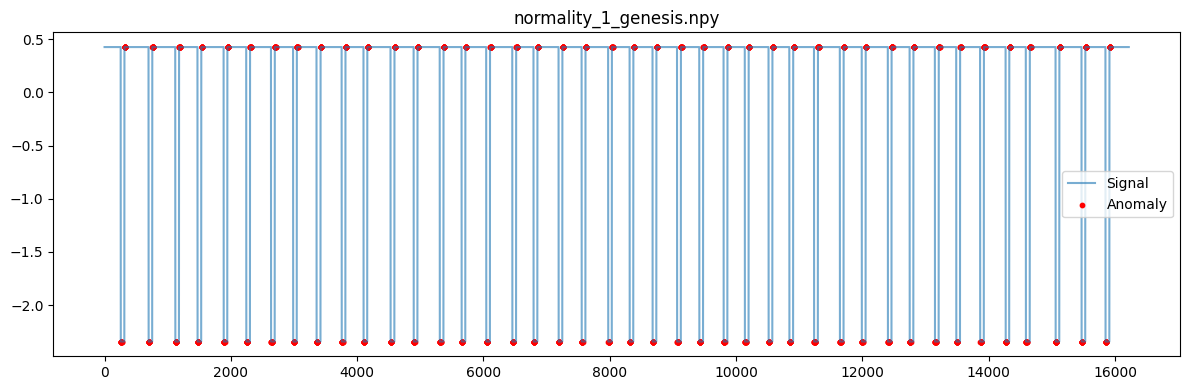


▶️ Processing normality_1_nasa-msl.npy
   ▶️  Fitting with: pattern_len=10, subseq_len=20, init_len=400, batch_size=300


c:\Users\maria\OneDrive\Υπολογιστής\ΜΕΤΑΠΤΥΧΙΑΚΟ\BIG DATA MINING\Streamify-Time-Series\venv310\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
c:\Users\maria\OneDrive\Υπολογιστής\ΜΕΤΑΠΤΥΧΙΑΚΟ\BIG DATA MINING\Streamify-Time-Series\venv310\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
c:\Users\maria\OneDrive\Υπολογιστής\ΜΕΤΑΠΤΥΧΙΑΚΟ\BIG DATA MINING\Streamify-Time-Series\venv310\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
c:\Users\maria\OneDrive\Υπολογιστής\ΜΕΤΑΠΤΥΧΙΑΚΟ\BIG DATA MINING\Streamify-Time-Series\venv310\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 

   ✅ Precision: 0.005, Recall: 0.005, F1: 0.005, AUC: 0.575


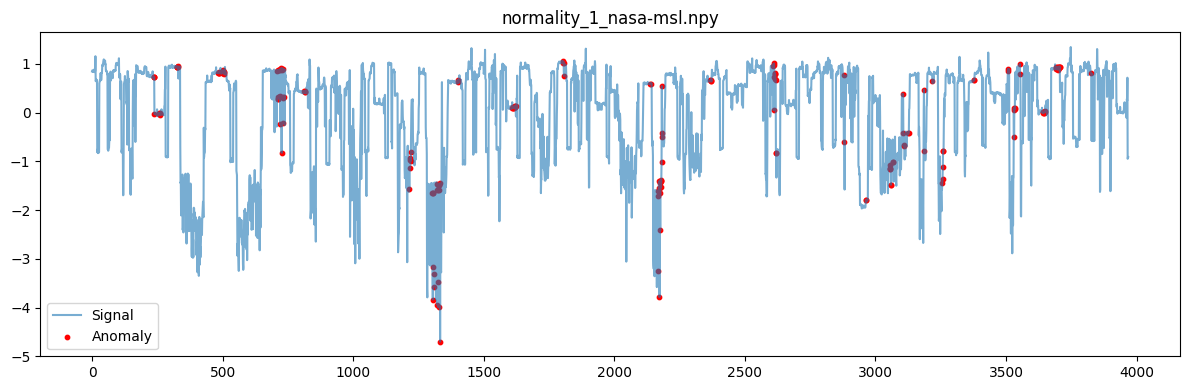


▶️ Processing normality_2_1_daphnet_genesis.npy
   ▶️  Fitting with: pattern_len=10, subseq_len=20, init_len=400, batch_size=300


c:\Users\maria\OneDrive\Υπολογιστής\ΜΕΤΑΠΤΥΧΙΑΚΟ\BIG DATA MINING\Streamify-Time-Series\venv310\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
c:\Users\maria\OneDrive\Υπολογιστής\ΜΕΤΑΠΤΥΧΙΑΚΟ\BIG DATA MINING\Streamify-Time-Series\venv310\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
c:\Users\maria\OneDrive\Υπολογιστής\ΜΕΤΑΠΤΥΧΙΑΚΟ\BIG DATA MINING\Streamify-Time-Series\venv310\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
c:\Users\maria\OneDrive\Υπολογιστής\ΜΕΤΑΠΤΥΧΙΑΚΟ\BIG DATA MINING\Streamify-Time-Series\venv310\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 

   ✅ Precision: 0.056, Recall: 0.056, F1: 0.056, AUC: 0.520


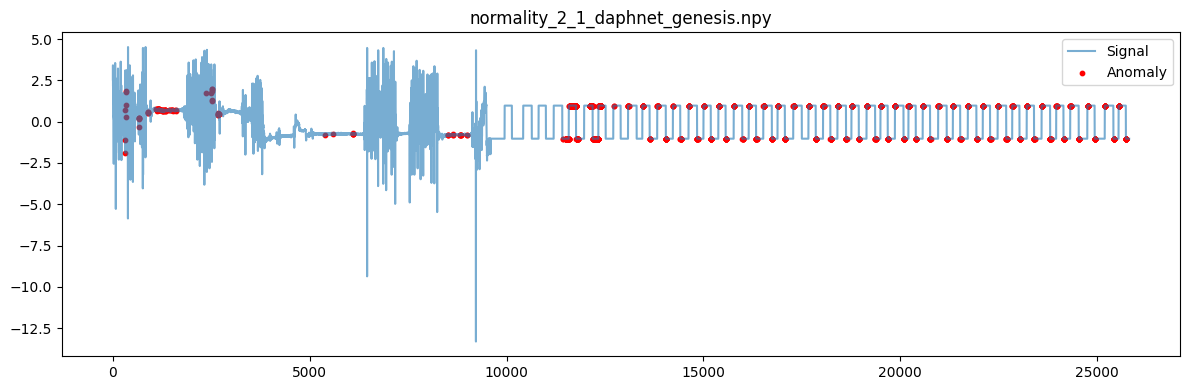


▶️ Processing normality_2_2_daphnet_nasa-msl.npy
   ▶️  Fitting with: pattern_len=10, subseq_len=20, init_len=400, batch_size=300


c:\Users\maria\OneDrive\Υπολογιστής\ΜΕΤΑΠΤΥΧΙΑΚΟ\BIG DATA MINING\Streamify-Time-Series\venv310\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
c:\Users\maria\OneDrive\Υπολογιστής\ΜΕΤΑΠΤΥΧΙΑΚΟ\BIG DATA MINING\Streamify-Time-Series\venv310\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
c:\Users\maria\OneDrive\Υπολογιστής\ΜΕΤΑΠΤΥΧΙΑΚΟ\BIG DATA MINING\Streamify-Time-Series\venv310\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
c:\Users\maria\OneDrive\Υπολογιστής\ΜΕΤΑΠΤΥΧΙΑΚΟ\BIG DATA MINING\Streamify-Time-Series\venv310\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 

   ✅ Precision: 0.035, Recall: 0.035, F1: 0.035, AUC: 0.439


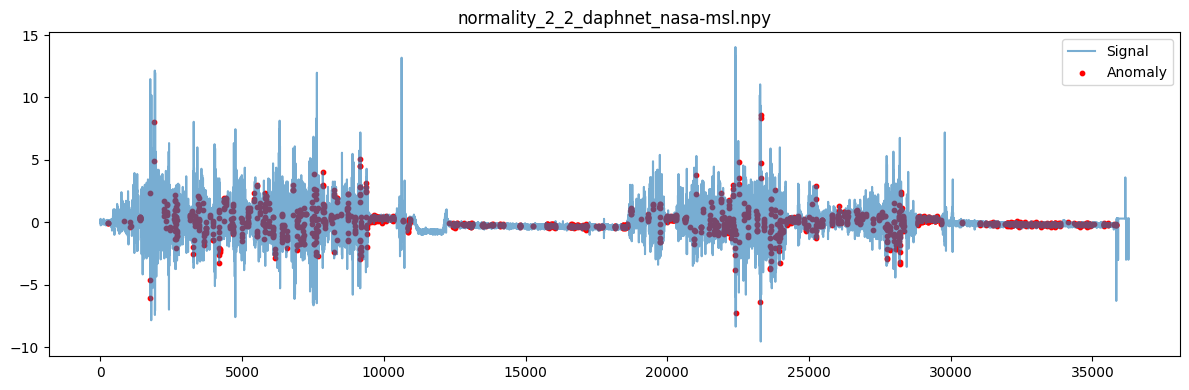


▶️ Processing normality_2_3_genesis_nasa-msl.npy
   ▶️  Fitting with: pattern_len=10, subseq_len=20, init_len=400, batch_size=300


c:\Users\maria\OneDrive\Υπολογιστής\ΜΕΤΑΠΤΥΧΙΑΚΟ\BIG DATA MINING\Streamify-Time-Series\venv310\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
c:\Users\maria\OneDrive\Υπολογιστής\ΜΕΤΑΠΤΥΧΙΑΚΟ\BIG DATA MINING\Streamify-Time-Series\venv310\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
c:\Users\maria\OneDrive\Υπολογιστής\ΜΕΤΑΠΤΥΧΙΑΚΟ\BIG DATA MINING\Streamify-Time-Series\venv310\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
c:\Users\maria\OneDrive\Υπολογιστής\ΜΕΤΑΠΤΥΧΙΑΚΟ\BIG DATA MINING\Streamify-Time-Series\venv310\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 

   ✅ Precision: 0.000, Recall: 0.000, F1: 0.000, AUC: 0.000


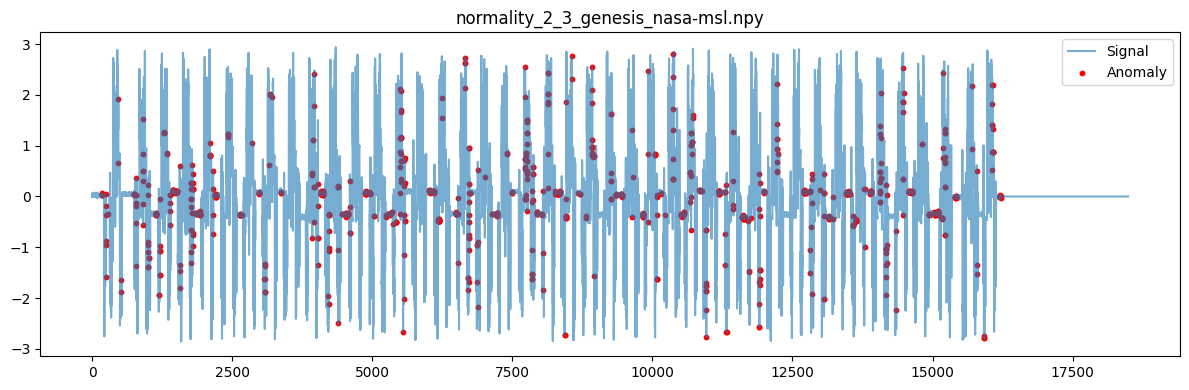


▶️ Processing normality_3_1_daphnet_genesis_nasa-msl.npy
   ▶️  Fitting with: pattern_len=10, subseq_len=20, init_len=400, batch_size=300


c:\Users\maria\OneDrive\Υπολογιστής\ΜΕΤΑΠΤΥΧΙΑΚΟ\BIG DATA MINING\Streamify-Time-Series\venv310\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
c:\Users\maria\OneDrive\Υπολογιστής\ΜΕΤΑΠΤΥΧΙΑΚΟ\BIG DATA MINING\Streamify-Time-Series\venv310\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
c:\Users\maria\OneDrive\Υπολογιστής\ΜΕΤΑΠΤΥΧΙΑΚΟ\BIG DATA MINING\Streamify-Time-Series\venv310\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
c:\Users\maria\OneDrive\Υπολογιστής\ΜΕΤΑΠΤΥΧΙΑΚΟ\BIG DATA MINING\Streamify-Time-Series\venv310\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 

   ✅ Precision: 0.197, Recall: 0.197, F1: 0.197, AUC: 0.646


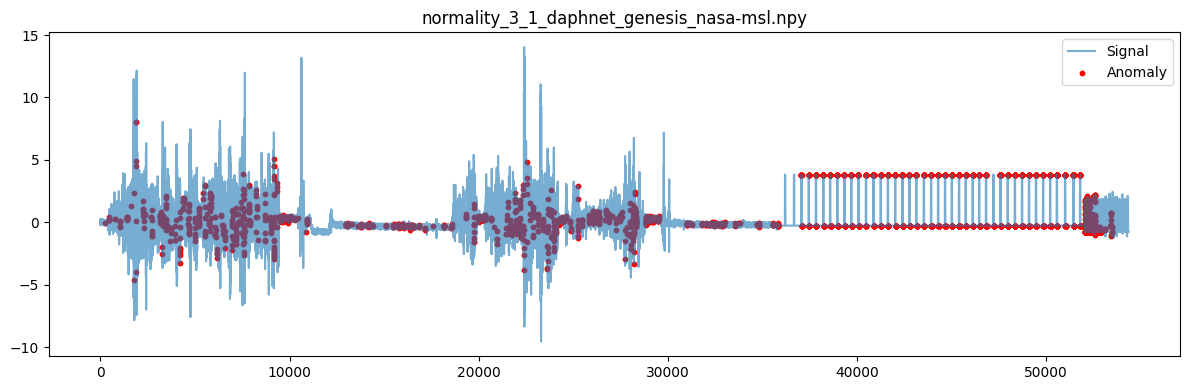


▶️ Processing normality_3_2_genesis_nasa-msl_daphnet.npy
   ▶️  Fitting with: pattern_len=10, subseq_len=20, init_len=400, batch_size=300


c:\Users\maria\OneDrive\Υπολογιστής\ΜΕΤΑΠΤΥΧΙΑΚΟ\BIG DATA MINING\Streamify-Time-Series\venv310\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
c:\Users\maria\OneDrive\Υπολογιστής\ΜΕΤΑΠΤΥΧΙΑΚΟ\BIG DATA MINING\Streamify-Time-Series\venv310\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
c:\Users\maria\OneDrive\Υπολογιστής\ΜΕΤΑΠΤΥΧΙΑΚΟ\BIG DATA MINING\Streamify-Time-Series\venv310\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
c:\Users\maria\OneDrive\Υπολογιστής\ΜΕΤΑΠΤΥΧΙΑΚΟ\BIG DATA MINING\Streamify-Time-Series\venv310\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 

   ✅ Precision: 0.013, Recall: 0.013, F1: 0.013, AUC: 0.508


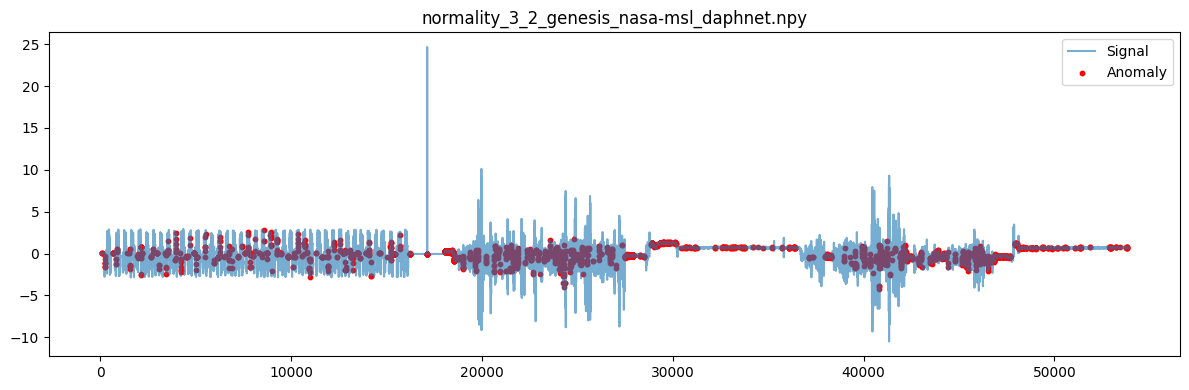


▶️ Processing normality_3_3_nasa-msl_daphnet_genesis.npy
   ▶️  Fitting with: pattern_len=10, subseq_len=20, init_len=400, batch_size=300


c:\Users\maria\OneDrive\Υπολογιστής\ΜΕΤΑΠΤΥΧΙΑΚΟ\BIG DATA MINING\Streamify-Time-Series\venv310\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
c:\Users\maria\OneDrive\Υπολογιστής\ΜΕΤΑΠΤΥΧΙΑΚΟ\BIG DATA MINING\Streamify-Time-Series\venv310\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
c:\Users\maria\OneDrive\Υπολογιστής\ΜΕΤΑΠΤΥΧΙΑΚΟ\BIG DATA MINING\Streamify-Time-Series\venv310\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
c:\Users\maria\OneDrive\Υπολογιστής\ΜΕΤΑΠΤΥΧΙΑΚΟ\BIG DATA MINING\Streamify-Time-Series\venv310\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 

   ✅ Precision: 0.060, Recall: 0.060, F1: 0.060, AUC: 0.506


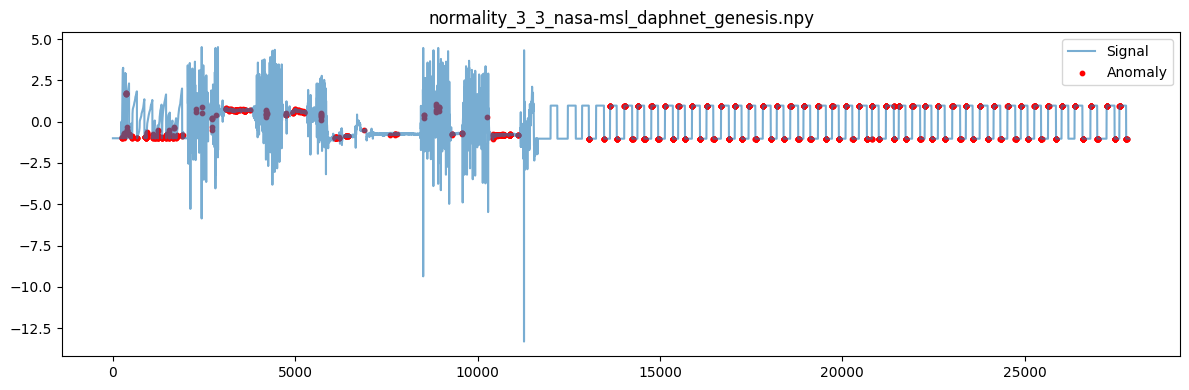

In [ ]:
# Run streaming SAND on all datasets
summary = []

for fname in sorted(os.listdir(DATA_DIR)):
    if not fname.endswith(".npy") or "_boundaries" in fname:
        continue

    print(f"\n Processing {fname}")
    ts = np.load(os.path.join(DATA_DIR, fname))

    preds, scores = run_sand_stream(ts)
    if preds is None or scores is None:
        print("Skipped: No predictions")
        continue

    labels = np.zeros(len(scores))
    labels[-int(len(scores) * CONTAMINATION):] = 1

    p = precision_score(labels, preds, zero_division=0)
    r = recall_score(labels, preds, zero_division=0)
    f = f1_score(labels, preds, zero_division=0)
    a = roc_auc_score(labels, scores) if len(set(labels)) > 1 else 0.0

    print(f"Precision: {p:.3f}, Recall: {r:.3f}, F1: {f:.3f}, AUC: {a:.3f}")

    plt.figure(figsize=(12, 4))
    plt.plot(ts, label="Signal", alpha=0.6)
    centers = np.where(preds == 1)[0] + SUBSEQ_LEN // 2
    centers = centers[centers < len(ts)]
    plt.scatter(centers, ts[centers], color='red', s=10, label="Anomaly")
    plt.title(fname)
    plt.legend()
    plt.tight_layout()
    plt.show()

    summary.append(dict(dataset=fname, length=len(ts),
                        precision=round(p, 3),
                        recall=round(r, 3),
                        f1=round(f, 3),
                        auc=round(a, 3)))

In [ ]:
# Save results
if summary:
    df = pd.DataFrame(summary).set_index("dataset")
    display(df)
    df.to_csv(os.path.join(RESULTS_DIR, "sand_streaming_results.csv"))
else:
    print("No datasets were successfully processed.")

,length,precision,recall,f1,auc
dataset,,,,,
normality_1_daphnet.npy,35840,0.015,0.015,0.015,0.478
normality_1_genesis.npy,16220,0.044,0.044,0.044,0.167
normality_1_nasa-msl.npy,3969,0.005,0.005,0.005,0.575
normality_2_1_daphnet_genesis.npy,25820,0.056,0.056,0.056,0.520
normality_2_2_daphnet_nasa-msl.npy,36279,0.035,0.035,0.035,0.439
normality_2_3_genesis_nasa-msl.npy,18492,0.000,0.000,0.000,0.000
normality_3_1_daphnet_genesis_nasa-msl.npy,54363,0.197,0.197,0.197,0.646
normality_3_2_genesis_nasa-msl_daphnet.npy,53887,0.013,0.013,0.013,0.508
normality_3_3_nasa-msl_daphnet_genesis.npy,27871,0.060,0.060,0.060,0.506
